In [1]:
import cv2
import torch
import kornia
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from utils import warp_image
from utils import image_shape_to_corners
from utils import four_point_to_homography

# Prepare image

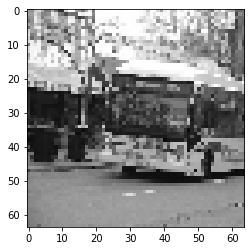

In [3]:
def load_image(filepath):
    image_bgr_np = cv2.imread(filepath)
    image_bgr_np = image_bgr_np[:, :428]
    image_bgr_np = cv2.resize(image_bgr_np, (64, 64))
    image_np = np.expand_dims(cv2.cvtColor(image_bgr_np, cv2.COLOR_BGR2GRAY), axis=-1)
    plt.imshow(np.tile(image_np, (1, 1, 3)))
    return image_np
image_np = load_image('COCO_val2014_000000000641.jpg')

# Prepare synthetic data gen

In [4]:
def prepare_train_sample(delta_np=None, visualize=False):
    if delta_np is None:
        delta_np = np.random.randint(-8, 8, 8).reshape(4, 2)
    corners_np = image_shape_to_corners(np.expand_dims(np.transpose(image_np, (2, 0, 1)), axis=0))
    homography_np = four_point_to_homography(corners_np, np.expand_dims(delta_np, axis=0))
    image_warped_np = warp_image(image_np, homography_np, target_h=image_np.shape[0], target_w=image_np.shape[1], inverse=False)
    image_warped_np = np.expand_dims(image_warped_np, axis=-1)
    if visualize:
        plt.imshow(np.tile(image_warped_np, (1, 1, 3)))
    return image_warped_np, corners_np[0], delta_np, homography_np

Original image shape: (64, 64, 1)
Warped image shape: (64, 64, 1)
Image corners shape: (4, 2)
Ground truth delta shape: (4, 2)
Ground truth homography shape: (3, 3)


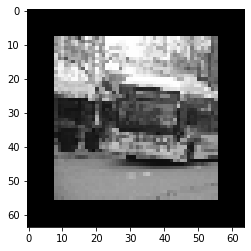

In [5]:
# Hand-defined warp
ret = prepare_train_sample(delta_np = np.array([[8, 8], [-8, 8], [-8, -8], [8, -8]]),
                           visualize=True)
print('Original image shape: {}'.format(image_np.shape))
print('Warped image shape: {}'.format(ret[0].shape))
print('Image corners shape: {}'.format(ret[1].shape))
print('Ground truth delta shape: {}'.format(ret[2].shape))
print('Ground truth homography shape: {}'.format(ret[3].shape))

Original image shape: (64, 64, 1)
Warped image shape: (64, 64, 1)
Image corners shape: (4, 2)
Ground truth delta shape: (4, 2)
Ground truth homography shape: (3, 3)


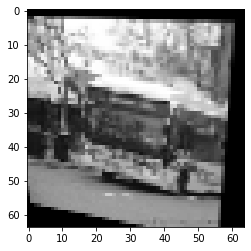

In [6]:
# Random warp
ret = prepare_train_sample(visualize=True)
print('Original image shape: {}'.format(image_np.shape))
print('Warped image shape: {}'.format(ret[0].shape))
print('Image corners shape: {}'.format(ret[1].shape))
print('Ground truth delta shape: {}'.format(ret[2].shape))
print('Ground truth homography shape: {}'.format(ret[3].shape))

# Target perspective field

In [7]:
def create_gt_perspective_field(h, w, homography, corners):
    
    # Create grid of targets
    y_grid, x_grid = np.mgrid[0:h, 0:w]
    point_grid = np.vstack((x_grid.flatten(), y_grid.flatten())).transpose()

    # Transform grid of points
    point_grid_t = cv2.perspectiveTransform(np.array([point_grid], dtype=np.float32), homography).squeeze()
    diff_grid_t = point_grid_t - point_grid
    diff_x_grid_t = diff_grid_t[:, 0]
    diff_y_grid_t = diff_grid_t[:, 1]
    diff_x_grid_t = diff_x_grid_t.reshape((h, w))
    diff_y_grid_t = diff_y_grid_t.reshape((h, w))

    pf_patch_x_branch = diff_x_grid_t[corners[0, 1]:corners[3, 1], corners[0, 0]:corners[1, 0]]
    pf_patch_y_branch = diff_y_grid_t[corners[0, 1]:corners[3, 1], corners[0, 0]:corners[1, 0]]

    # Create target
    target = np.zeros((h, w, 2))
    target[:, :, 0] = pf_patch_x_branch
    target[:, :, 1] = pf_patch_y_branch
    return target

def visualize_perspective_field(perspective_field, corners, image_1, homography, no_of_random_points=5):

    target = np.tile(image_1.astype(np.uint8), (1, 1, 3))
    random_points = np.random.choice(min(target.shape[0], target.shape[1]), no_of_random_points*2)
    for h, w in zip([0, 0, target.shape[0] - 1, target.shape[0] - 1, corners[0, 1]] + random_points[:no_of_random_points].tolist(),
                    [0, target.shape[1] - 1, 0, target.shape[1] - 1, corners[0, 0]] + random_points[no_of_random_points:].tolist()):
        x = perspective_field[h, w, 0].astype(int)
        y = perspective_field[h, w, 1].astype(int)
        cv2.arrowedLine(target, (w, h), (w + x, h + y), color=(255, 0, 0), thickness=1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    
    ax1.imshow(np.tile(image_1.astype(np.uint8), (1, 1, 3)))
    ax1.set_title('orig_image')

    image_2 = warp_image(image_1, homography, target_h=image_np.shape[0], target_w=image_np.shape[1], inverse=False)
    image_2 = np.expand_dims(image_2, axis=-1)
    ax2.imshow(np.tile(image_2.astype(np.uint8), (1, 1, 3)))
    ax2.set_title('warped_image')
    
    ax3.imshow(target)
    ax3.set_title('pf')
    plt.show()

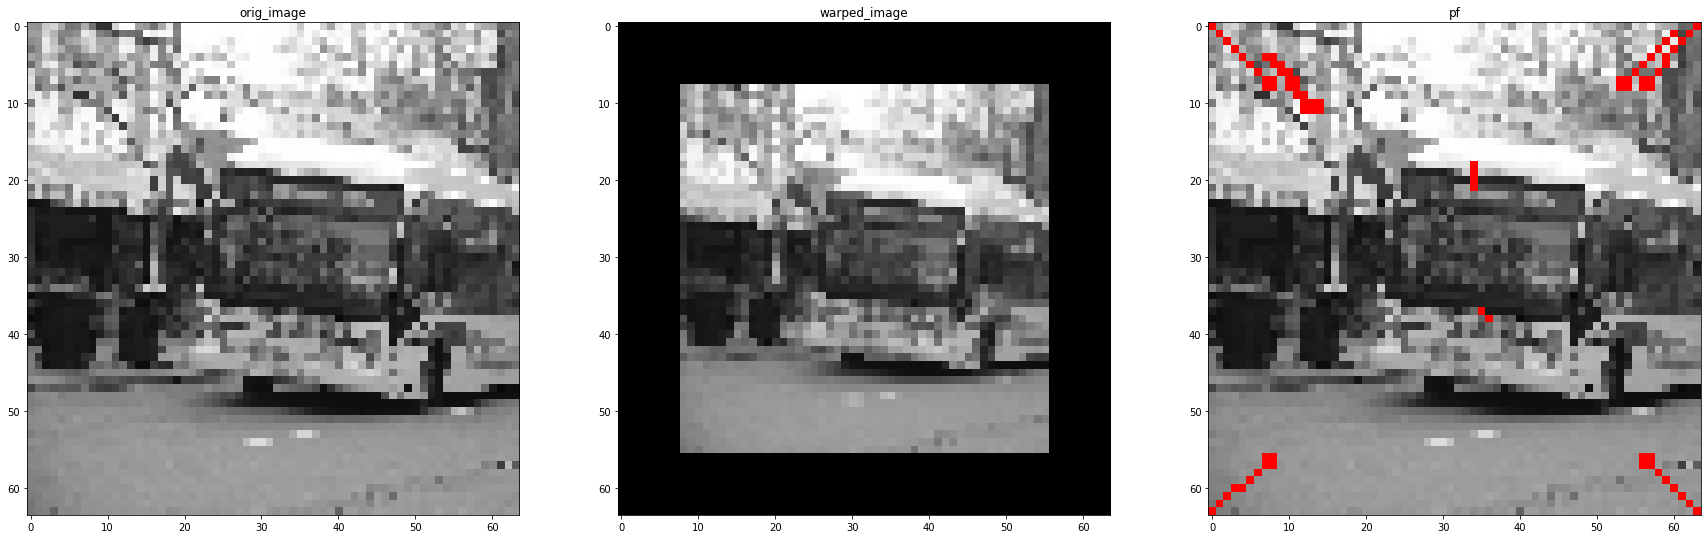

In [8]:

# Create hand-designed warp
_, corners_np, _, homography_np = prepare_train_sample(delta_np = np.array([[8, 8], [-8, 8], [-8, -8], [8, -8]]),
                                                       visualize=False)

# Create perspective field
pf_gt_np = create_gt_perspective_field(h=image_np.shape[0], w=image_np.shape[1],
                                       homography=homography_np, corners=corners_np.astype(int))

# Visualize perspective field
visualize_perspective_field(pf_gt_np, corners=corners_np.astype(int), image_1=image_np,
                            homography=homography_np)

In [11]:
import torch
from typing import Tuple

import kornia
from kornia.geometry.epipolar import normalize_points

TupleTensor = Tuple[torch.Tensor, torch.Tensor]


def find_homography_dlt(points1: torch.Tensor, points2: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
    r"""Computes the homography matrix using the DLT formulation.
    The linear system is solved by using the Weighted Least Squares Solution for the 4 Points algorithm.
    Args:
        points1 (torch.Tensor): A set of points in the first image with a tensor shape :math:`(B, N, 2)`.
        points2 (torch.Tensor): A set of points in the second image with a tensor shape :math:`(B, N, 2)`.
        weights (torch.Tensor): Tensor containing the weights per point correspondence with a shape of :math:`(B, N)`.
    Returns:
        torch.Tensor: the computed homography matrix with shape :math:`(B, 3, 3)`.
    """
    assert points1.shape == points2.shape, points1.shape
    assert len(points1.shape) >= 1 and points1.shape[-1] == 2, points1.shape
    assert points1.shape[1] >= 4, points1.shape

    eps: float = 1e-8
    points1_norm, transform1 = normalize_points(points1)
    points2_norm, transform2 = normalize_points(points2)

    x1, y1 = torch.chunk(points1_norm, dim=-1, chunks=2)  # BxNx1
    x2, y2 = torch.chunk(points2_norm, dim=-1, chunks=2)  # BxNx1
    ones, zeros = torch.ones_like(x1), torch.zeros_like(x1)

    # DIAPO 11: https://www.uio.no/studier/emner/matnat/its/nedlagte-emner/UNIK4690/v16/forelesninger/lecture_4_3-estimating-homographies-from-feature-correspondences.pdf  # noqa: E501
    ax = torch.cat([zeros, zeros, zeros, -x1, -y1, -ones, y2 * x1, y2 * y1, y2], dim=-1)
    ay = torch.cat([x1, y1, ones, zeros, zeros, zeros, -x2 * x1, -x2 * y1, -x2], dim=-1)

    w_list = []
    axy_list = []
    for i in range(points1.shape[1]):
        axy_list.append(ax[:, i])
        axy_list.append(ay[:, i])
        w_list.append(weights[:, i])
        w_list.append(weights[:, i])
    A = torch.stack(axy_list, dim=1)
    w = torch.stack(w_list, dim=1)

    # apply weights
    w_diag = torch.diag_embed(w)
    A = A.transpose(-2, -1) @ w_diag @ A
    try:
        U, S, V = torch.svd(A)
    except:
        print ('Fail!')
        return torch.empty(points1_norm.size(0), 3, 3)
    H = V[..., -1].view(-1, 3, 3)
    H = transform2.inverse() @ (H @ transform1)
    print (f'last element={H[..., -1:, -1:]}')
    H_norm = H / (H[..., -1:, -1:] + eps)
    return H_norm


# Create field of coordinates (help func training)

In [12]:
def create_coord_field(image_size):
    # Create field of the coordinates
    y_patch_grid, x_patch_grid = np.mgrid[0:image_size, 0:image_size]
    x_patch_grid = x_patch_grid.reshape(-1)
    y_patch_grid = y_patch_grid.reshape(-1)
    coordinate_field = np.stack((x_patch_grid, y_patch_grid), axis=0).transpose(1, 0)
    return coordinate_field

coord_field_np = create_coord_field(image_size=64)
coord_field_torch = torch.from_numpy(np.expand_dims(coord_field_np, axis=0).astype(np.float32))

# Create four points (help func for training)

In [13]:
four_points_np = np.array([[0, 0], [image_np.shape[1], 0],
                           [image_np.shape[1], image_np.shape[0]],
                           [0, image_np.shape[0]]])
four_points_torch = torch.from_numpy(np.expand_dims(four_points_np, axis=0)).float()

# Define sample model

In [14]:
class Model(nn.Module):

    def __init__(self, verbose=False):
        super(Model, self).__init__()
        self.verbose = verbose
        
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=2, out_channels=64, kernel_size=5, padding=2, stride=1, bias=False),
                                    nn.GroupNorm(4, 64),
                                    #nn.BatchNorm2d(64),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1, bias=False),
                                    #nn.BatchNorm2d(128),
                                    nn.GroupNorm(4, 128),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1, bias=False),
                                    #nn.BatchNorm2d(128),
                                    nn.GroupNorm(4, 128),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1, bias=False),
                                   # nn.BatchNorm2d(128),
                                    nn.GroupNorm(4, 128),
                                    nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1, bias=False),
                                    #nn.BatchNorm2d(128),
                                    nn.GroupNorm(4, 128),
                                    nn.ReLU())
        self.layer6 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=2, kernel_size=3, padding=1, stride=1, bias=True),
                                   # nn.BatchNorm2d(2),
                                   # nn.ReLU()
                                   )

    def forward(self, x):
        if self.verbose:
            print('Do we have nans in the input: ', torch.any(torch.logical_not(torch.isfinite(x))).item())
        
        out = self.layer1(x)
        
        if self.verbose:
            print('Do we have nans after first conv: ', torch.any(torch.logical_not(torch.isfinite(out))).item())
            for a in self.layer1.named_parameters():
                print('Param name: {} mean value: {} '.format(a[0], torch.mean(a[1]).item()))
        
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        return out

# Training loop - fails!

In [15]:
import kornia as K
plt.imshow(K.tensor_to_image(model_input[0,1]))

NameError: name 'model_input' is not defined

In [16]:
model = Model()
model.train()
pf_hat_torch = model.forward(model_input)
    

NameError: name 'model_input' is not defined

In [17]:
model = Model()
model.train()

lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
loss_fn = torch.nn.MSELoss()

for step in range(100):
    
    # Prepare ground truth
    image_warped_np, corners_np, delta_gt_np, hom_gt_np = prepare_train_sample()
    #print (hom_gt_np)
    #image_warped_np, corners_np, delta_gt_np, hom_gt_np = prepare_train_sample(delta_np = np.array([[8, 8], [-8, 8], [-8, -8], [8, -8]]),
    #                                                   visualize=False)

    # Prepare input to the model
    model_input = np.concatenate([image_np, image_warped_np], axis=-1)
    model_input = np.expand_dims(np.transpose(model_input, (2, 0, 1)), axis=0)
    model_input = torch.from_numpy(model_input.astype(np.float32))
    
    # Forward pass
    optimizer.zero_grad()
    pf_hat_torch = model.forward(model_input)
    
    # Prepare data for homography
    pf_hat_torch = pf_hat_torch.reshape(1, 2, -1).permute(0, 2, 1)
    map_field_torch = coord_field_torch + pf_hat_torch
    weights_torch = torch.ones((1, map_field_torch.shape[1]), dtype=torch.float32)
    #print (map_field_torch.max(), map_field_torch.min())
    # Use kornia to estimate homography
    homography_hat_torch = find_homography_dlt(coord_field_torch,
                                                      map_field_torch,
                                                      weights_torch)
    print (homography_hat_torch)
    # Transform corners
    four_points_transformed_torch = kornia.transform_points(homography_hat_torch,
                                                            four_points_torch)
    
    # Estimate delta hat
    delta_hat_torch = four_points_transformed_torch - four_points_torch
    
    # Loss 
    delta_gt_torch = torch.from_numpy(np.expand_dims(delta_gt_np, axis=0))
    loss = loss_fn(delta_gt_torch, delta_hat_torch)
    
    # calc gradients
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)
    print('LOSS: {} '.format(loss.item()))
    #print (four_points_torch)
    #print (four_points_transformed_torch)
    # Optimize
    optimizer.step()

last element=tensor([[[0.5787]]], grad_fn=<SliceBackward>)
tensor([[[ 9.9787e-01, -5.7579e-03,  7.2409e-01],
         [ 1.3124e-03,  9.9002e-01,  5.5031e-01],
         [ 4.0529e-05, -1.1245e-04,  1.0000e+00]]], grad_fn=<DivBackward0>)


/home/old-ufo/anaconda3/envs/fastai1/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


LOSS: 18.51899528503418 
last element=tensor([[[0.5775]]], grad_fn=<SliceBackward>)
tensor([[[ 9.9573e-01,  2.7166e-03, -1.5720e-02],
         [-1.4938e-03,  1.0026e+00, -2.4032e-01],
         [-6.0746e-05,  4.8831e-05,  1.0000e+00]]], grad_fn=<DivBackward0>)
LOSS: 9.666606903076172 
Fail!
tensor([[[1.2710e+11, 4.5853e-41, 1.9685e-14],
         [3.0941e-41, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# More verbose training loop

In [34]:
model = Model(verbose=True)
model.train()

lr = 1e-10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

for step in range(100):
    
    # Prepare ground truth
    image_warped_np, corners_np, delta_gt_np, hom_gt_np = prepare_train_sample()
    
    # Prepare input to the model
    model_input = np.concatenate([image_np, image_warped_np], axis=-1)
    model_input = np.expand_dims(np.transpose(model_input, (2, 0, 1)), axis=0)
    model_input = torch.from_numpy(model_input.astype(np.float32))
    
    # Forward pass
    optimizer.zero_grad()
    pf_hat_torch = model.forward(model_input)
    
    # Prepare data for homography
    pf_hat_torch = pf_hat_torch.reshape(1, 2, -1).permute(0, 2, 1)
    map_field_torch = coord_field_torch + pf_hat_torch
    weights_torch = torch.ones((1, map_field_torch.shape[1]), dtype=torch.float32)
    
    # Use kornia to estimate homography
    homography_hat_torch = kornia.find_homography_dlt(coord_field_torch,
                                                      map_field_torch,
                                                      weights_torch)
    
    # Transform corners
    four_points_transformed_torch = kornia.transform_points(homography_hat_torch,
                                                            four_points_torch)
    
    # Estimate delta hat
    delta_hat_torch = four_points_transformed_torch - four_points_torch
    
    # Loss 
    delta_gt_torch = torch.from_numpy(np.expand_dims(delta_gt_np, axis=0))
    loss = loss_fn(delta_gt_torch, delta_hat_torch)
    
    # Calc norm of gradients
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    
    # calc gradients
    loss.backward()
    print('LOSS: {} Norm of gradients: {}\n'.format(loss.item(), total_norm))

    # Optimize
    optimizer.step()

Do we have nans in the input:  False
Do we have nans after first conv:  False
Param name: 0.weight mean value: 0.001154365367256105 
Param name: 1.weight mean value: 1.0 
Param name: 1.bias mean value: 0.0 
LOSS: 30.18286895751953 Norm of gradients: 0.0

Do we have nans in the input:  False
Do we have nans after first conv:  True
Param name: 0.weight mean value: nan 
Param name: 1.weight mean value: nan 
Param name: 1.bias mean value: nan 


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn